In [1]:
import jax 
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import os 
import scanpy as sc
import pandas as pd
from tqdm import tqdm
from jax import vmap
import tangram as tg

In [2]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import seaborn as sns
import tangram as tg

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

%load_ext autoreload
%autoreload 2
%matplotlib inline

scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.22.2 scipy==1.7.1 pandas==1.3.4 scikit-learn==1.0.1 statsmodels==0.13.1 python-igraph==0.9.9 pynndescent==0.5.5
squidpy==1.1.2


In [3]:
adata_st = sq.datasets.visium_fluo_adata_crop()
adata_st = adata_st[
    adata_st.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])
].copy()
img = sq.datasets.visium_fluo_image_crop()

adata_sc = sq.datasets.sc_mouse_cortex()

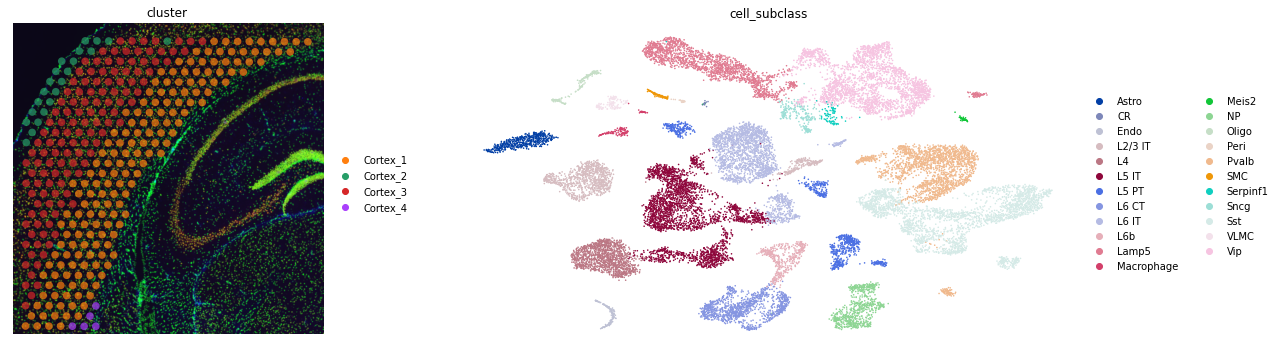

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sc.pl.spatial(
    adata_st, color="cluster", alpha=0.7, frameon=False, show=False, ax=axs[0]
)
sc.pl.umap(
    adata_sc, color="cell_subclass", size=10, frameon=False, show=False, ax=axs[1]
)
plt.tight_layout()


In [5]:
sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass", use_raw=False)
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
markers = list(np.unique(markers_df.melt().value.values))
len(markers)

1401

In [6]:
tg.pp_adatas(adata_sc, adata_st, genes=markers)


INFO:root:1280 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:14785 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [7]:
assert adata_sc.uns['training_genes'] == adata_st.uns['training_genes']


In [8]:
training_genes = adata_sc.uns["training_genes"]
S = np.array(adata_sc[:, training_genes].X.toarray(), dtype="float32",)
G = np.array(adata_st[:, training_genes].X.toarray(), dtype="float32")

In [9]:
S.shape, G.shape

((21697, 1280), (324, 1280))

In [10]:
from  optax import cosine_similarity as cosim
from functools import partial
from jax import value_and_grad
import optax

In [11]:
seed = 42
key = jax.random.PRNGKey(seed)

INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


In [12]:

d_true  = G.sum(axis = 1) / np.sum(G)

n_cells, n_genes = S.shape
n_voxels, n_genes = G.shape

### initialize optimization problem ### 
M = jax.random.normal(key, (n_cells, n_voxels))
M = jax.nn.softmax(M , axis = -1)


In [13]:
def kl_div(y_true, y_pred):

    kl_loss = y_true * (jnp.log(y_true + 1e-20)  - jnp.log(y_pred + 1e-20))
    return kl_loss.sum()


def loss_fn(M, G, S, d_true):
    
    M = jax.nn.softmax(M , axis = -1)
    d_pred = M.sum(axis = 0)/M.shape[0]
    
    sc_projected_in_space = jnp.dot(M.T, S)
    exp_term = cosim(sc_projected_in_space.T, G.T, epsilon = 1e-20).mean()
    kl_loss = kl_div(d_true, d_pred)
    ### density term
    loss = -exp_term  + kl_loss
    
    
    return loss

In [14]:
start_learning_rate = 1e-1
optimizer = optax.adam(start_learning_rate)

# Initialize parameters of the model + optimizer.
params = M
opt_state = optimizer.init(params)

In [15]:
loss_func = partial(loss_fn, G = G, S = S, d_true = d_true)
#loss_func = jax.jit(loss_func)
v_ang_g_func = jax.jit(jax.value_and_grad(loss_func))

In [16]:
losses = []
for _ in tqdm(range(300)):
    loss, grads = v_ang_g_func(params)
    
    if _%50 == 0:
        print(loss)
    
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    
    if _%20 == 0:
        params_ = jax.nn.softmax(params, axis = -1)
        sc_space = jnp.dot(params_.T, S)
        main_loss = cosim(sc_space.T, G.T, 1e-20).mean()
        
        #sc_space_torch = torch.tensor(np.asarray(sc_space))
        #G_torch = torch.tensor(np.asarray(G))
        #cos_torch =  cosine_similarity(sc_space_torch, G_torch, dim = 0).mean()
        
        
        d_pred_ =  params_.sum(axis = 0)/params_.shape[0]
        kl_loss = kl_div(d_true, d_pred_)
        
        
        #kl_torch = torch.nn.KLDivLoss(reduction="sum")

        #d_pred_log = torch.log(torch.tensor(np.asarray(d_pred_)))
        #d_true_torch = torch.tensor(np.asarray(d_true))

        #kl_t = kl_torch(d_pred_log, d_true_torch)
        
        #print (f"Main Loss {cos_torch},  kl_reg: {kl_t}   Torch losses ")
        
        print (f"Main Loss {main_loss},  kl_reg: {kl_loss}")
    
    
    losses.append(loss)

  0%|          | 0/300 [00:00<?, ?it/s]

-0.6124969


  1%|          | 2/300 [00:02<05:41,  1.15s/it]

Main Loss 0.616929829120636,  kl_reg: 0.0001266554172616452


  7%|▋         | 22/300 [00:05<00:36,  7.66it/s]

Main Loss 0.6659359335899353,  kl_reg: 0.00014491414185613394


 14%|█▍        | 42/300 [00:07<00:33,  7.81it/s]

Main Loss 0.6995291709899902,  kl_reg: 0.00013725628377869725


 17%|█▋        | 52/300 [00:08<00:28,  8.81it/s]

-0.71251273


 21%|██        | 62/300 [00:09<00:30,  7.86it/s]

Main Loss 0.7260343432426453,  kl_reg: 0.00011374492896720767


 27%|██▋       | 82/300 [00:12<00:27,  7.80it/s]

Main Loss 0.7377687096595764,  kl_reg: 9.407784091308713e-05


 34%|███▎      | 101/300 [00:14<00:26,  7.41it/s]

-0.7400145
Main Loss 0.7401551604270935,  kl_reg: 8.873356273397803e-05


 41%|████      | 122/300 [00:16<00:21,  8.19it/s]

Main Loss 0.7407572269439697,  kl_reg: 8.747371612116694e-05


 47%|████▋     | 142/300 [00:19<00:19,  8.09it/s]

Main Loss 0.741016149520874,  kl_reg: 8.771155262365937e-05


 51%|█████     | 152/300 [00:20<00:17,  8.41it/s]

-0.74100465


 54%|█████▍    | 162/300 [00:21<00:17,  7.83it/s]

Main Loss 0.7411664128303528,  kl_reg: 8.766743121668696e-05


 61%|██████    | 182/300 [00:23<00:15,  7.71it/s]

Main Loss 0.7412659525871277,  kl_reg: 8.733314462006092e-05


 67%|██████▋   | 201/300 [00:25<00:13,  7.54it/s]

-0.74124575
Main Loss 0.7413362860679626,  kl_reg: 8.737272582948208e-05


 74%|███████▍  | 222/300 [00:28<00:09,  8.18it/s]

Main Loss 0.7413930296897888,  kl_reg: 8.747627725824714e-05


 81%|████████  | 242/300 [00:30<00:07,  8.11it/s]

Main Loss 0.7414408922195435,  kl_reg: 8.739001350477338e-05


 84%|████████▍ | 252/300 [00:31<00:05,  8.72it/s]

-0.74137104


 87%|████████▋ | 262/300 [00:33<00:05,  7.46it/s]

Main Loss 0.7414770126342773,  kl_reg: 8.730439003556967e-05


 94%|█████████▍| 282/300 [00:35<00:02,  8.20it/s]

Main Loss 0.7415074706077576,  kl_reg: 8.733663707971573e-05


100%|██████████| 300/300 [00:37<00:00,  8.00it/s]


In [17]:
M = jax.nn.softmax(params, axis = -1)

In [18]:
from tangram.utils import one_hot_encoding
from tangram.plot_utils import plot_cell_annotation_sc, plot_training_scores
from tangram.utils import annotate_gene_sparsity

In [19]:
adata_map = sc.AnnData(
        X=np.asarray(M),
        obs=adata_sc[:, training_genes].obs.copy(),
        var=adata_st[:, training_genes].obs.copy(),
    )


In [20]:
G_predicted = adata_map.X.T @ S

cos_sims = np.asarray(cosim(G_predicted.T, G.T, epsilon = 1e-20))

df_cs = pd.DataFrame(cos_sims, training_genes, columns=["train_score"])
df_cs = df_cs.sort_values(by="train_score", ascending=False)
adata_map.uns["train_genes_df"] = df_cs

annotate_gene_sparsity(adata_sc)
annotate_gene_sparsity(adata_st)
adata_map.uns["train_genes_df"]["sparsity_sc"] = adata_sc[
    :, training_genes
].var.sparsity
adata_map.uns["train_genes_df"]["sparsity_sp"] = adata_st[
    :, training_genes
].var.sparsity
adata_map.uns["train_genes_df"]["sparsity_diff"] = (
    adata_st[:, training_genes].var.sparsity
    - adata_sc[:, training_genes].var.sparsity
)


In [22]:
adata_map

AnnData object with n_obs × n_vars = 21697 × 324
    obs: 'sample_name', 'organism', 'donor_sex', 'cell_class', 'cell_subclass', 'cell_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster', 'uniform_density', 'rna_count_based_density'
    uns: 'train_genes_df'

In [23]:
annotation = "cell_subclass"

In [24]:
df = one_hot_encoding(adata_map.obs[annotation])

In [25]:
df_ct_prob = adata_map.X.T @ df
df_ct_prob.index = adata_map.var.index

In [26]:
adata_st.obsm["tangram_ct_pred"] = df_ct_prob

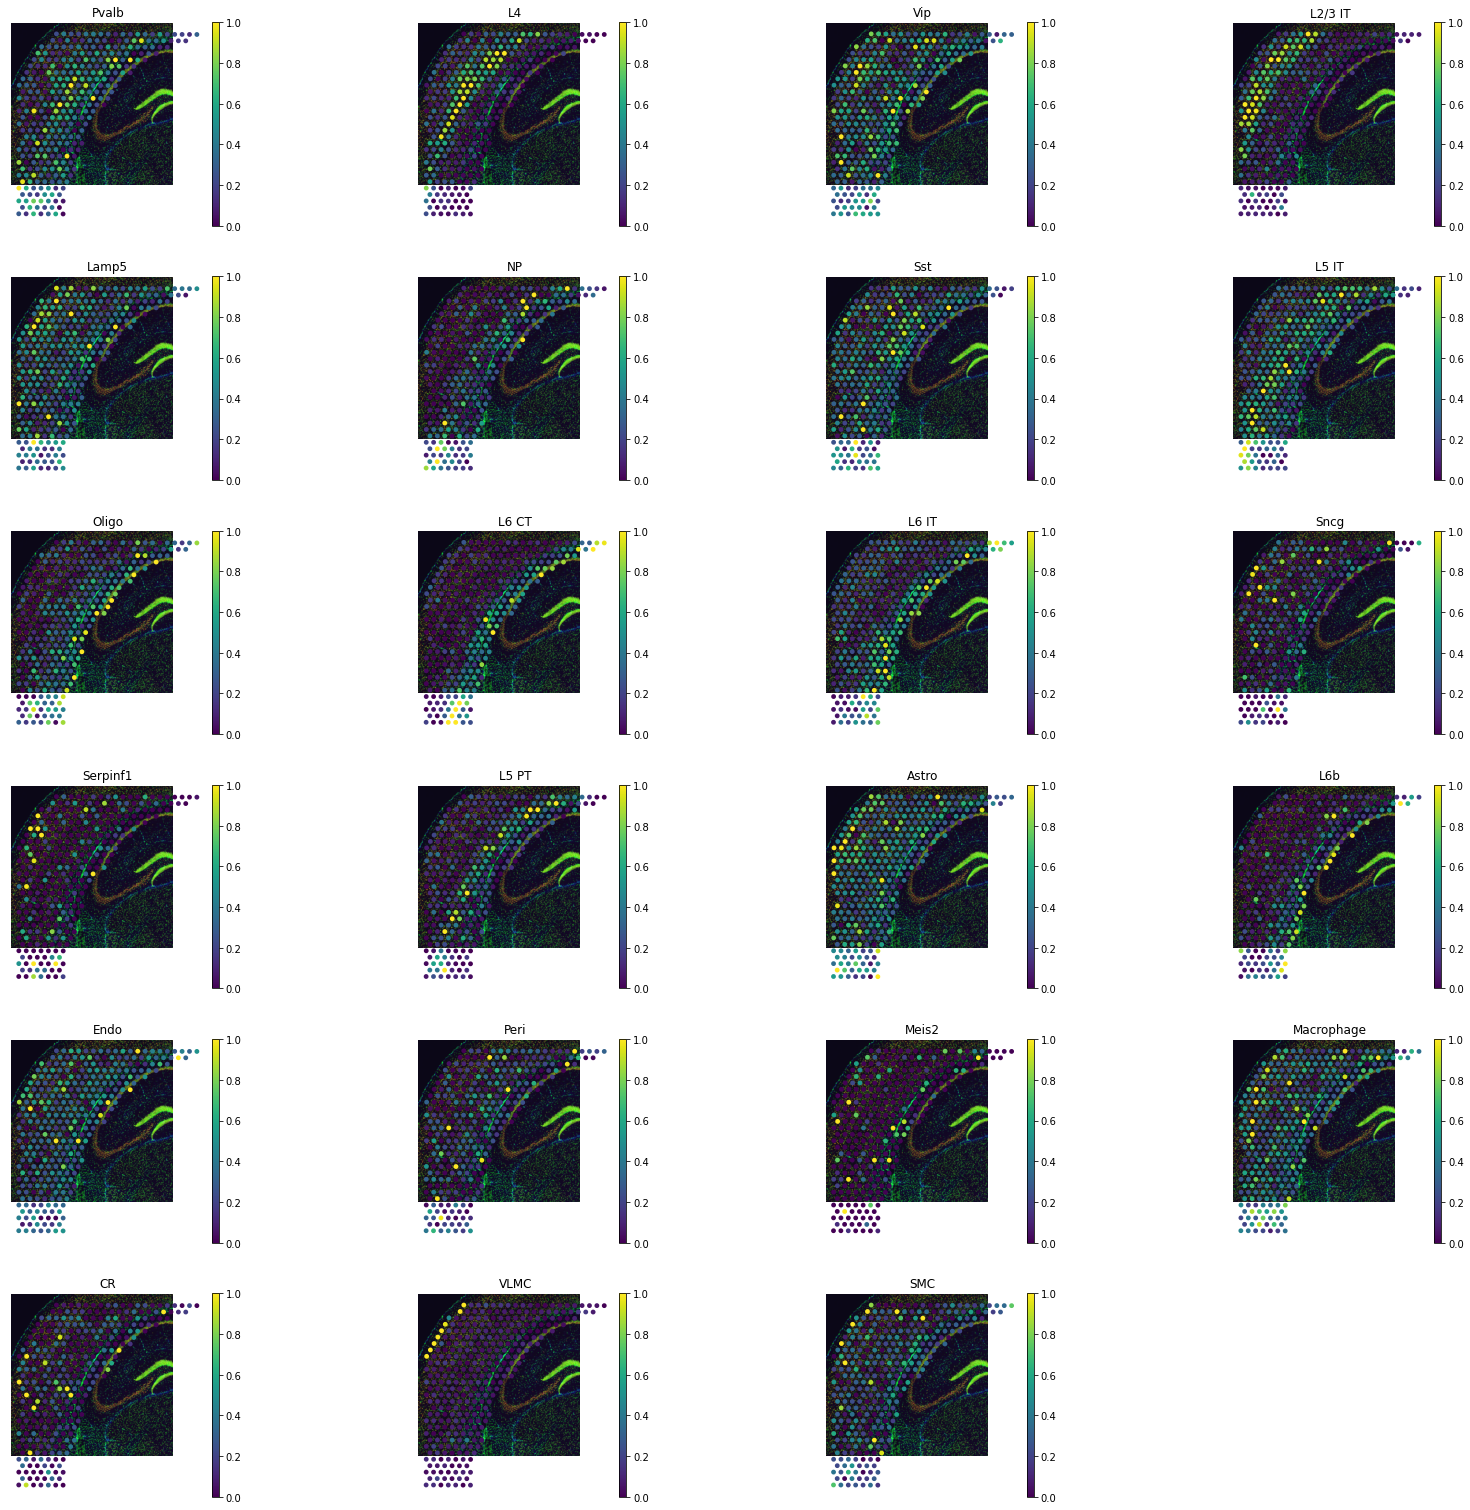

In [28]:
annotation_list = list(pd.unique(adata_sc.obs['cell_subclass']))

plot_cell_annotation_sc(adata_st, annotation_list, perc=0.02)


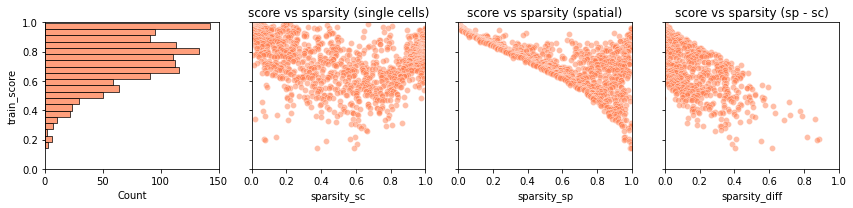

In [29]:
tg.plot_training_scores(adata_map, bins=20, alpha=.5)


In [30]:
ad_ge = tg.project_genes(adata_map=adata_map, adata_sc=adata_sc)
ad_ge

AnnData object with n_obs × n_vars = 324 × 36826
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster', 'uniform_density', 'rna_count_based_density'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'sparsity', 'is_training'
    uns: 'cell_class_colors', 'cell_subclass_colors', 'hvg', 'neighbors', 'pca', 'umap', 'rank_genes_groups', 'training_genes', 'overlap_genes'

In [31]:
df_all_genes = tg.compare_spatial_geneexp(ad_ge, adata_st, adata_sc)
df_all_genes

score  is_training  sparsity_sp  sparsity_sc  sparsity_diff
gapdh          0.998299        False     0.000000     0.000968      -0.000968
snap25         0.997958        False     0.000000     0.014610      -0.014610
ppia           0.997886         True     0.000000     0.000092      -0.000092
calm1          0.997866        False     0.000000     0.000369      -0.000369
calm2          0.997484        False     0.000000     0.001751      -0.001751
...                 ...          ...          ...          ...            ...
tmprss11a      0.000032        False     0.996914     0.997880      -0.000966
irx5           0.000031        False     0.996914     0.999447      -0.002533
cckar          0.000030        False     0.996914     0.999309      -0.002395
6330420h09rik  0.000029        False     0.996914     0.998894      -0.001980
clec12a        0.000026        False     0.996914     0.998848      -0.001934

[14785 rows x 5 columns]

<Figure size 432x288 with 0 Axes>

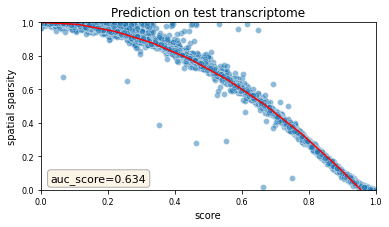

In [32]:
# sns.scatterplot(data=df_all_genes, x='score', y='sparsity_sp', hue='is_training', alpha=.5);  # for legacy
tg.plot_auc(df_all_genes);

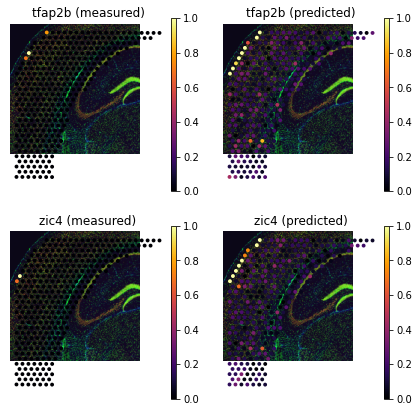

In [33]:
genes=['tfap2b', 'zic4']
tg.plot_genes_sc(genes, adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02)

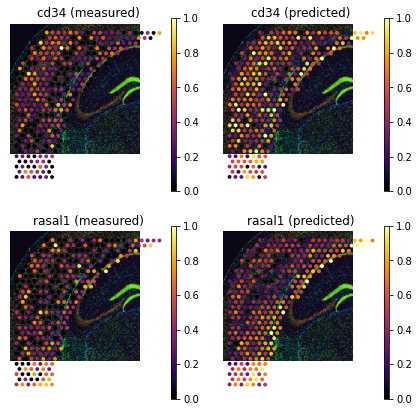

In [34]:

genes = ['cd34', 'rasal1']
tg.plot_genes_sc(genes, adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02)

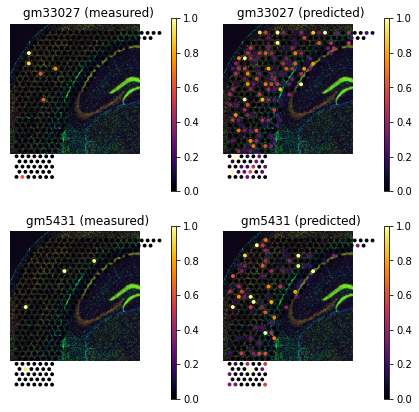

In [35]:
genes = ['gm33027', 'gm5431']
tg.plot_genes_sc(genes[:5], adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02)

In [36]:
sq.im.process(img=img, layer="image", method="smooth")
sq.im.segment(
    img=img,
    layer="image_smooth",
    method="watershed",
    channel=0,
)

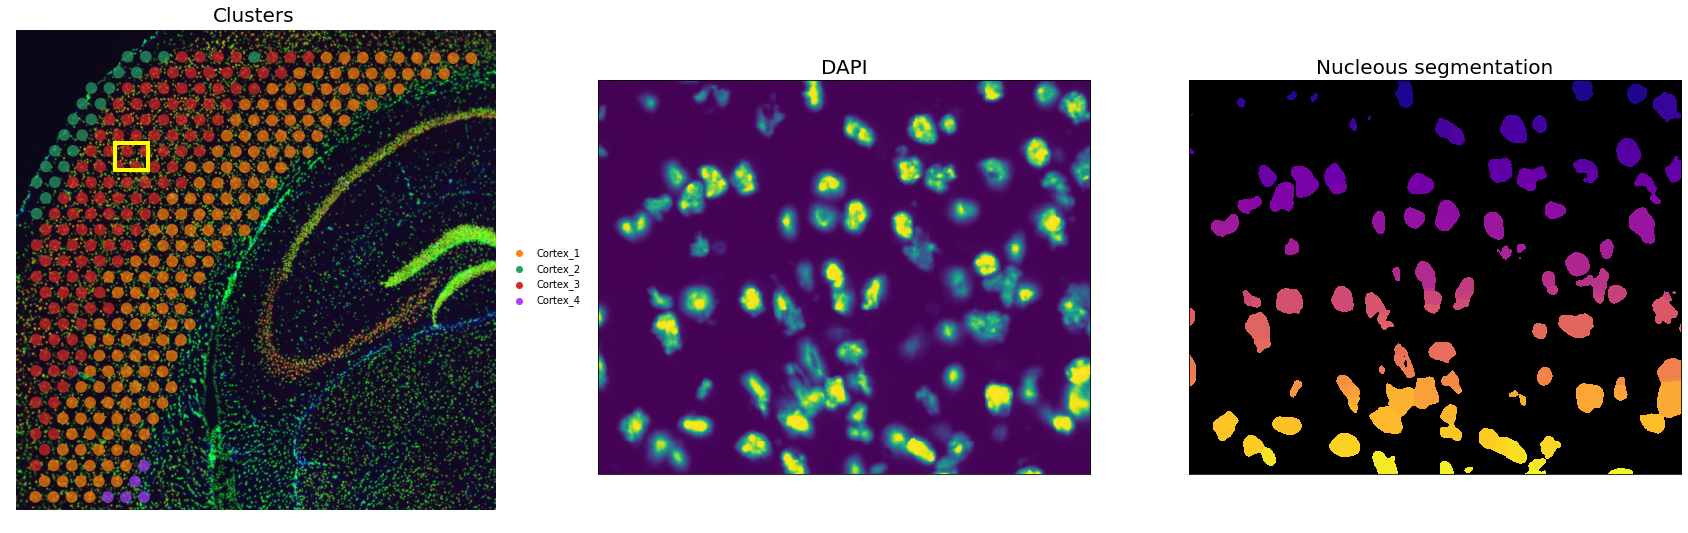

In [37]:
inset_y = 1500
inset_x = 1700
inset_sy = 400
inset_sx = 500

fig, axs = plt.subplots(1, 3, figsize=(30, 10))
sc.pl.spatial(
    adata_st, color="cluster", alpha=0.7, frameon=False, show=False, ax=axs[0], title=""
)
axs[0].set_title("Clusters", fontdict={"fontsize": 20})
sf = adata_st.uns["spatial"]["V1_Adult_Mouse_Brain_Coronal_Section_2"]["scalefactors"][
    "tissue_hires_scalef"
]
rect = mpl.patches.Rectangle(
    (inset_y * sf, inset_x * sf),
    width=inset_sx * sf,
    height=inset_sy * sf,
    ec="yellow",
    lw=4,
    fill=False,
)
axs[0].add_patch(rect)

axs[0].axes.xaxis.label.set_visible(False)
axs[0].axes.yaxis.label.set_visible(False)

axs[1].imshow(
    img["image"][inset_y : inset_y + inset_sy, inset_x : inset_x + inset_sx, 0, 0]
    / 65536,
    interpolation="none",
)
axs[1].grid(False)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("DAPI", fontdict={"fontsize": 20})

crop = img["segmented_watershed"][
    inset_y : inset_y + inset_sy, inset_x : inset_x + inset_sx
].values.squeeze(-1)
crop = skimage.segmentation.relabel_sequential(crop)[0]
cmap = plt.cm.plasma
cmap.set_under(color="black")
axs[2].imshow(crop, interpolation="none", cmap=cmap, vmin=0.001)
axs[2].grid(False)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Nucleous segmentation", fontdict={"fontsize": 20});

In [38]:
# define image layer to use for segmentation
features_kwargs = {
    "segmentation": {
        "label_layer": "segmented_watershed",
        "props": ["label", "centroid"],
        "channels": [1, 2],
    }
}
# calculate segmentation features
sq.im.calculate_image_features(
    adata_st,
    img,
    layer="image",
    key_added="image_features",
    features_kwargs=features_kwargs,
    features="segmentation",
    mask_circle=True,
)

  0%|          | 0/324 [00:00<?, ?/s]

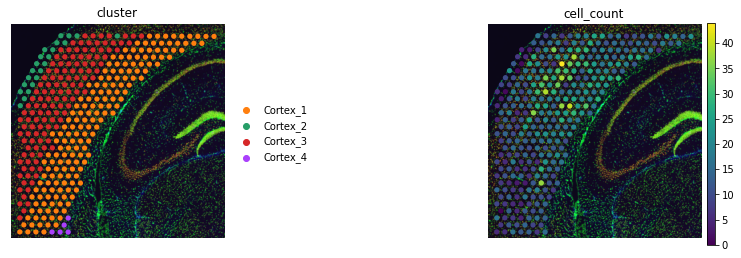

In [39]:
adata_st.obs["cell_count"] = adata_st.obsm["image_features"]["segmentation_label"]
sc.pl.spatial(adata_st, color=["cluster", "cell_count"], frameon=False)

## Deconvolution via spatial alignment 

In [106]:
seed = 42
key = jax.random.PRNGKey(seed)
key1, key2 = jax.random.split(key, 2)

In [107]:
d_true = jnp.array(adata_st.obs.cell_count) / adata_st.obs.cell_count.sum()

n_cells, n_genes = S.shape
n_voxels, n_genes = G.shape

### initialize optimization problem ### 
M = jax.random.normal(key1, (n_cells, n_voxels))
M = jax.nn.softmax(M , axis = -1)
f = jax.random.normal(key2, (n_cells, ))
f = jax.nn.sigmoid(f)
cnt_cells = adata_st.obs.cell_count.sum()

In [108]:
def kl_div(y_true, y_pred):

    kl_loss = y_true * (jnp.log(y_true + 1e-20)  - jnp.log(y_pred + 1e-20))
    return kl_loss.sum()


def loss_fn_filter(M, f, G, S, d_true, cnt_cells):
    
    M = jax.nn.softmax(M , axis = -1)
    f = jax.nn.sigmoid(f)
    
    M_f = M * f[:, jnp.newaxis]
    S_f = S * f[:, jnp.newaxis]
    
    d_pred = M_f.sum(axis = 0) / jnp.sum(f)
    
    sc_projected_in_space = jnp.dot(M.T, S_f)
    
    exp_term_1 = cosim(sc_projected_in_space.T, G.T, epsilon = 1e-20).mean()
    #exp_term_2 = cosim(sc_projected_in_space, G, epsilon = 1e-20).mean()
    exp_term = exp_term_1 #+ exp_term_2
    
    
    kl_loss = kl_div(d_true, d_pred)
    ### count term
    cnt_loss = jnp.abs(jnp.sum(f) - cnt_cells)
    ### f_reg
    
    f_reg = jnp.sum(f - f**2)
    
    
    
    ### density term
    loss = -exp_term  + kl_loss + cnt_loss + f_reg
    
    
    return loss

In [109]:
start_learning_rate = 1e-1
optimizer = optax.adam(start_learning_rate)

# Initialize parameters of the model + optimizer.
params = (M, f)
opt_state = optimizer.init(params)

In [110]:
loss_func = partial(loss_fn_filter, G = G, S = S, d_true = d_true, cnt_cells = adata_st.obs.cell_count.sum())
#loss_func = jax.jit(loss_func)
v_ang_g_func = jax.jit(jax.value_and_grad(loss_func, argnums = (0, 1)))

In [111]:
losses = []
for _ in tqdm(range(1000)):
    M, f = params
    loss, grads = v_ang_g_func(M, f)
    
    if _%50 == 0:
        print(loss)
    
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    
    if _%20 == 0:
        M_, f_ = params
        
        
        M = jax.nn.softmax(M_ , axis = -1)
        f = jax.nn.sigmoid(f_)

        #f_diag = jnp.diag(f)
        M_f = M * f[:, jnp.newaxis]
        S_f = S * f[:, jnp.newaxis]

        d_pred = M_f.sum(axis = 0) / jnp.sum(f)

        sc_projected_in_space = jnp.dot(M.T, S_f)

        exp_term_1 = cosim(sc_projected_in_space.T, G.T, epsilon = 1e-20).mean()
        exp_term_2 = cosim(sc_projected_in_space, G, epsilon = 1e-20).mean()
        exp_term = exp_term_1 #+ exp_term_2
        
        kl_loss = kl_div(d_true, d_pred)
        ### count term
        cnt_loss = jnp.abs(jnp.sum(f) - cnt_cells)
        ### f_reg

        f_reg = jnp.sum(f - f**2)
                
        print (f"Main Loss {exp_term_1},  kl_reg: {kl_loss}, cnt_loss: {cnt_loss}, f_reg_loss : {f_reg} ")
    
    
    losses.append(loss)

  0%|          | 1/1000 [00:02<40:25,  2.43s/it]

13403.455
Main Loss 0.6134724617004395,  kl_reg: 0.09449048340320587, cnt_loss: 7842.5576171875, f_reg_loss : 5160.76025390625 


  2%|▏         | 22/1000 [00:06<03:29,  4.67it/s]

Main Loss 0.6230626106262207,  kl_reg: 0.014448415488004684, cnt_loss: 1256.953857421875, f_reg_loss : 3168.37060546875 


  4%|▍         | 42/1000 [00:10<03:14,  4.92it/s]

Main Loss 0.6545481085777283,  kl_reg: 0.01201625820249319, cnt_loss: 1889.06982421875, f_reg_loss : 2722.920166015625 


  5%|▌         | 52/1000 [00:12<02:45,  5.73it/s]

4381.5205


  6%|▌         | 62/1000 [00:14<03:15,  4.80it/s]

Main Loss 0.6845928430557251,  kl_reg: 0.011631096713244915, cnt_loss: 53.5341796875, f_reg_loss : 3602.10888671875 


  8%|▊         | 82/1000 [00:17<03:12,  4.77it/s]

Main Loss 0.7013325691223145,  kl_reg: 0.011915789917111397, cnt_loss: 88.29443359375, f_reg_loss : 2883.107421875 


 10%|█         | 101/1000 [00:21<03:10,  4.72it/s]

2065.904
Main Loss 0.704271137714386,  kl_reg: 0.012095610611140728, cnt_loss: 36.27001953125, f_reg_loss : 2030.017822265625 


 12%|█▏        | 122/1000 [00:25<02:58,  4.93it/s]

Main Loss 0.7037937045097351,  kl_reg: 0.012044846080243587, cnt_loss: 1.31396484375, f_reg_loss : 1321.303955078125 


 14%|█▍        | 142/1000 [00:29<02:55,  4.89it/s]

Main Loss 0.7032787203788757,  kl_reg: 0.01203058660030365, cnt_loss: 4.580078125, f_reg_loss : 886.3775024414062 


 15%|█▌        | 151/1000 [00:31<02:38,  5.37it/s]

758.422


 16%|█▌        | 162/1000 [00:33<02:56,  4.75it/s]

Main Loss 0.7030138969421387,  kl_reg: 0.012030411511659622, cnt_loss: 0.86279296875, f_reg_loss : 636.6719360351562 


 18%|█▊        | 182/1000 [00:37<02:44,  4.97it/s]

Main Loss 0.7028594017028809,  kl_reg: 0.012028960511088371, cnt_loss: 0.38818359375, f_reg_loss : 486.3330383300781 


 20%|██        | 201/1000 [00:40<02:57,  4.51it/s]

402.0679
Main Loss 0.7028143405914307,  kl_reg: 0.012025045230984688, cnt_loss: 0.197265625, f_reg_loss : 398.8969421386719 


 22%|██▏       | 221/1000 [00:44<02:47,  4.64it/s]

Main Loss 0.7028178572654724,  kl_reg: 0.012038739398121834, cnt_loss: 1.31982421875, f_reg_loss : 339.90716552734375 


 24%|██▍       | 241/1000 [00:48<02:35,  4.87it/s]

Main Loss 0.7027977108955383,  kl_reg: 0.012036880478262901, cnt_loss: 2.029296875, f_reg_loss : 300.25067138671875 


 25%|██▌       | 251/1000 [00:50<02:18,  5.41it/s]

287.9298


 26%|██▌       | 261/1000 [00:52<02:36,  4.71it/s]

Main Loss 0.7027866244316101,  kl_reg: 0.012049060314893723, cnt_loss: 1.525390625, f_reg_loss : 272.282958984375 


 28%|██▊       | 282/1000 [00:56<02:29,  4.81it/s]

Main Loss 0.7027906775474548,  kl_reg: 0.012057611718773842, cnt_loss: 1.21044921875, f_reg_loss : 250.76243591308594 


 30%|███       | 301/1000 [01:00<02:25,  4.81it/s]

235.2105
Main Loss 0.7028194665908813,  kl_reg: 0.012056329287588596, cnt_loss: 0.84619140625, f_reg_loss : 234.43675231933594 


 32%|███▏      | 322/1000 [01:04<02:27,  4.59it/s]

Main Loss 0.7028648257255554,  kl_reg: 0.012052561156451702, cnt_loss: 0.47412109375, f_reg_loss : 221.47207641601562 


 34%|███▍      | 341/1000 [01:08<02:34,  4.28it/s]

Main Loss 0.7029048204421997,  kl_reg: 0.012053202837705612, cnt_loss: 0.73583984375, f_reg_loss : 210.79409790039062 


 35%|███▌      | 351/1000 [01:10<02:11,  4.92it/s]

207.51978


 36%|███▌      | 362/1000 [01:12<02:19,  4.58it/s]

Main Loss 0.702924907207489,  kl_reg: 0.012061549350619316, cnt_loss: 1.12353515625, f_reg_loss : 202.4544219970703 


 38%|███▊      | 381/1000 [01:16<02:24,  4.28it/s]

Main Loss 0.7029353380203247,  kl_reg: 0.012052249163389206, cnt_loss: 1.06298828125, f_reg_loss : 194.1387176513672 


 40%|████      | 401/1000 [01:20<02:18,  4.32it/s]

189.90907
Main Loss 0.7029607892036438,  kl_reg: 0.012055671773850918, cnt_loss: 1.88525390625, f_reg_loss : 188.50485229492188 


 42%|████▏     | 421/1000 [01:24<02:07,  4.55it/s]

Main Loss 0.7029873728752136,  kl_reg: 0.012061519548296928, cnt_loss: 1.24853515625, f_reg_loss : 184.2068328857422 


 44%|████▍     | 442/1000 [01:29<01:59,  4.66it/s]

Main Loss 0.7030523419380188,  kl_reg: 0.012089294381439686, cnt_loss: 1.18359375, f_reg_loss : 179.12161254882812 


 45%|████▌     | 451/1000 [01:30<01:52,  4.86it/s]

176.87756


 46%|████▌     | 462/1000 [01:33<01:54,  4.72it/s]

Main Loss 0.7030683755874634,  kl_reg: 0.012084374204277992, cnt_loss: 0.78125, f_reg_loss : 173.80426025390625 


 48%|████▊     | 482/1000 [01:37<01:49,  4.71it/s]

Main Loss 0.7030752897262573,  kl_reg: 0.012082385830581188, cnt_loss: 0.36376953125, f_reg_loss : 168.0281219482422 


 50%|█████     | 501/1000 [01:41<01:51,  4.46it/s]

161.44254
Main Loss 0.7030639052391052,  kl_reg: 0.012080549262464046, cnt_loss: 1.5009765625, f_reg_loss : 160.35630798339844 


 52%|█████▏    | 522/1000 [01:45<01:44,  4.59it/s]

Main Loss 0.703061044216156,  kl_reg: 0.012074703350663185, cnt_loss: 0.8359375, f_reg_loss : 155.0032958984375 


 54%|█████▍    | 541/1000 [01:49<01:42,  4.48it/s]

Main Loss 0.7030721306800842,  kl_reg: 0.012084489688277245, cnt_loss: 0.81298828125, f_reg_loss : 150.08070373535156 


 55%|█████▌    | 551/1000 [01:51<01:28,  5.06it/s]

148.10603


 56%|█████▌    | 562/1000 [01:53<01:36,  4.56it/s]

Main Loss 0.7030671834945679,  kl_reg: 0.012073775753378868, cnt_loss: 0.8271484375, f_reg_loss : 145.65476989746094 


 58%|█████▊    | 582/1000 [01:57<01:28,  4.70it/s]

Main Loss 0.7030805945396423,  kl_reg: 0.012079400941729546, cnt_loss: 0.986328125, f_reg_loss : 141.7833251953125 


 60%|██████    | 601/1000 [02:01<01:27,  4.56it/s]

138.10713
Main Loss 0.7030870914459229,  kl_reg: 0.012085920199751854, cnt_loss: 0.8447265625, f_reg_loss : 137.74110412597656 


 62%|██████▏   | 621/1000 [02:05<01:25,  4.42it/s]

Main Loss 0.7030889391899109,  kl_reg: 0.012085361406207085, cnt_loss: 2.009765625, f_reg_loss : 134.00315856933594 


 64%|██████▍   | 642/1000 [02:09<01:18,  4.59it/s]

Main Loss 0.7031063437461853,  kl_reg: 0.01208498328924179, cnt_loss: 0.1953125, f_reg_loss : 133.55511474609375 


 65%|██████▌   | 651/1000 [02:11<01:09,  5.03it/s]

131.56572


 66%|██████▌   | 662/1000 [02:13<01:12,  4.68it/s]

Main Loss 0.7031121253967285,  kl_reg: 0.012087799608707428, cnt_loss: 0.63232421875, f_reg_loss : 130.14273071289062 


 68%|██████▊   | 681/1000 [02:17<01:10,  4.53it/s]

Main Loss 0.7031173706054688,  kl_reg: 0.012084973976016045, cnt_loss: 1.39697265625, f_reg_loss : 127.22266387939453 


 70%|███████   | 701/1000 [02:21<01:07,  4.42it/s]

125.051254
Main Loss 0.7031421661376953,  kl_reg: 0.012101364322006702, cnt_loss: 1.23486328125, f_reg_loss : 124.3884506225586 


 72%|███████▏  | 721/1000 [02:25<01:04,  4.35it/s]

Main Loss 0.7031434178352356,  kl_reg: 0.012094543315470219, cnt_loss: 0.79248046875, f_reg_loss : 122.8721694946289 


 74%|███████▍  | 742/1000 [02:29<00:54,  4.72it/s]

Main Loss 0.7031450271606445,  kl_reg: 0.01209637988358736, cnt_loss: 1.55859375, f_reg_loss : 120.81375122070312 


 75%|███████▌  | 751/1000 [02:31<00:47,  5.22it/s]

121.27976


 76%|███████▌  | 762/1000 [02:33<00:51,  4.63it/s]

Main Loss 0.7031586766242981,  kl_reg: 0.012098883278667927, cnt_loss: 1.0576171875, f_reg_loss : 120.08673858642578 


 78%|███████▊  | 782/1000 [02:37<00:46,  4.68it/s]

Main Loss 0.703159749507904,  kl_reg: 0.012095939368009567, cnt_loss: 1.28857421875, f_reg_loss : 118.53608703613281 


 80%|████████  | 801/1000 [02:41<00:43,  4.60it/s]

117.62284
Main Loss 0.703155517578125,  kl_reg: 0.012090668082237244, cnt_loss: 0.45703125, f_reg_loss : 117.689208984375 


 82%|████████▏ | 822/1000 [02:45<00:37,  4.72it/s]

Main Loss 0.7031497955322266,  kl_reg: 0.012094687670469284, cnt_loss: 1.16259765625, f_reg_loss : 114.65478515625 


 84%|████████▍ | 842/1000 [02:49<00:33,  4.78it/s]

Main Loss 0.7030758261680603,  kl_reg: 0.012098768725991249, cnt_loss: 1.24365234375, f_reg_loss : 112.45445251464844 


 85%|████████▌ | 851/1000 [02:51<00:28,  5.31it/s]

112.09711


 86%|████████▌ | 862/1000 [02:53<00:28,  4.81it/s]

Main Loss 0.7030026912689209,  kl_reg: 0.012083053588867188, cnt_loss: 0.1416015625, f_reg_loss : 111.18787384033203 


 88%|████████▊ | 882/1000 [02:57<00:24,  4.80it/s]

Main Loss 0.7030565142631531,  kl_reg: 0.012101366184651852, cnt_loss: 0.1767578125, f_reg_loss : 108.3489990234375 


 90%|█████████ | 901/1000 [03:01<00:22,  4.43it/s]

106.40564
Main Loss 0.7030577063560486,  kl_reg: 0.012102806940674782, cnt_loss: 1.7275390625, f_reg_loss : 105.3369140625 


 92%|█████████▏| 922/1000 [03:05<00:16,  4.67it/s]

Main Loss 0.7030618786811829,  kl_reg: 0.012099593877792358, cnt_loss: 0.26806640625, f_reg_loss : 104.71243286132812 


 94%|█████████▍| 942/1000 [03:09<00:12,  4.56it/s]

Main Loss 0.7030630111694336,  kl_reg: 0.012100327759981155, cnt_loss: 0.6806640625, f_reg_loss : 102.44788360595703 


 95%|█████████▌| 951/1000 [03:11<00:09,  5.24it/s]

101.67732


 96%|█████████▌| 962/1000 [03:13<00:08,  4.61it/s]

Main Loss 0.7030666470527649,  kl_reg: 0.012097392231225967, cnt_loss: 1.5302734375, f_reg_loss : 100.12754821777344 


 98%|█████████▊| 982/1000 [03:17<00:03,  4.74it/s]

Main Loss 0.7030755877494812,  kl_reg: 0.012102680280804634, cnt_loss: 0.73974609375, f_reg_loss : 99.68687438964844 


100%|██████████| 1000/1000 [03:20<00:00,  4.98it/s]


In [112]:
M_, f_ = params
        
        
M = jax.nn.softmax(M_ , axis = -1)
f = jax.nn.sigmoid(f_)

In [117]:
adata_map = sc.AnnData(
        X=np.asarray(M),
        obs=adata_sc[:, training_genes].obs.copy(),
        var=adata_st[:, training_genes].obs.copy(),
    )

In [118]:
adata_map.obs["F_out"] = f

In [119]:
G_predicted = adata_map.X.T @ S

cos_sims = np.asarray(cosim(G_predicted.T, G.T, epsilon = 1e-20))

df_cs = pd.DataFrame(cos_sims, training_genes, columns=["train_score"])
df_cs = df_cs.sort_values(by="train_score", ascending=False)
adata_map.uns["train_genes_df"] = df_cs

annotate_gene_sparsity(adata_sc)
annotate_gene_sparsity(adata_st)
adata_map.uns["train_genes_df"]["sparsity_sc"] = adata_sc[
    :, training_genes
].var.sparsity
adata_map.uns["train_genes_df"]["sparsity_sp"] = adata_st[
    :, training_genes
].var.sparsity
adata_map.uns["train_genes_df"]["sparsity_diff"] = (
    adata_st[:, training_genes].var.sparsity
    - adata_sc[:, training_genes].var.sparsity
)


In [122]:

threshold = .5
df = one_hot_encoding(adata_map.obs[annotation])
if "F_out" in adata_map.obs.keys():
    df_ct_prob = adata_map[adata_map.obs["F_out"] > threshold]

df_ct_prob = adata_map.X.T @ df
df_ct_prob.index = adata_map.var.index

adata_st.obsm["tangram_ct_pred"] = df_ct_prob


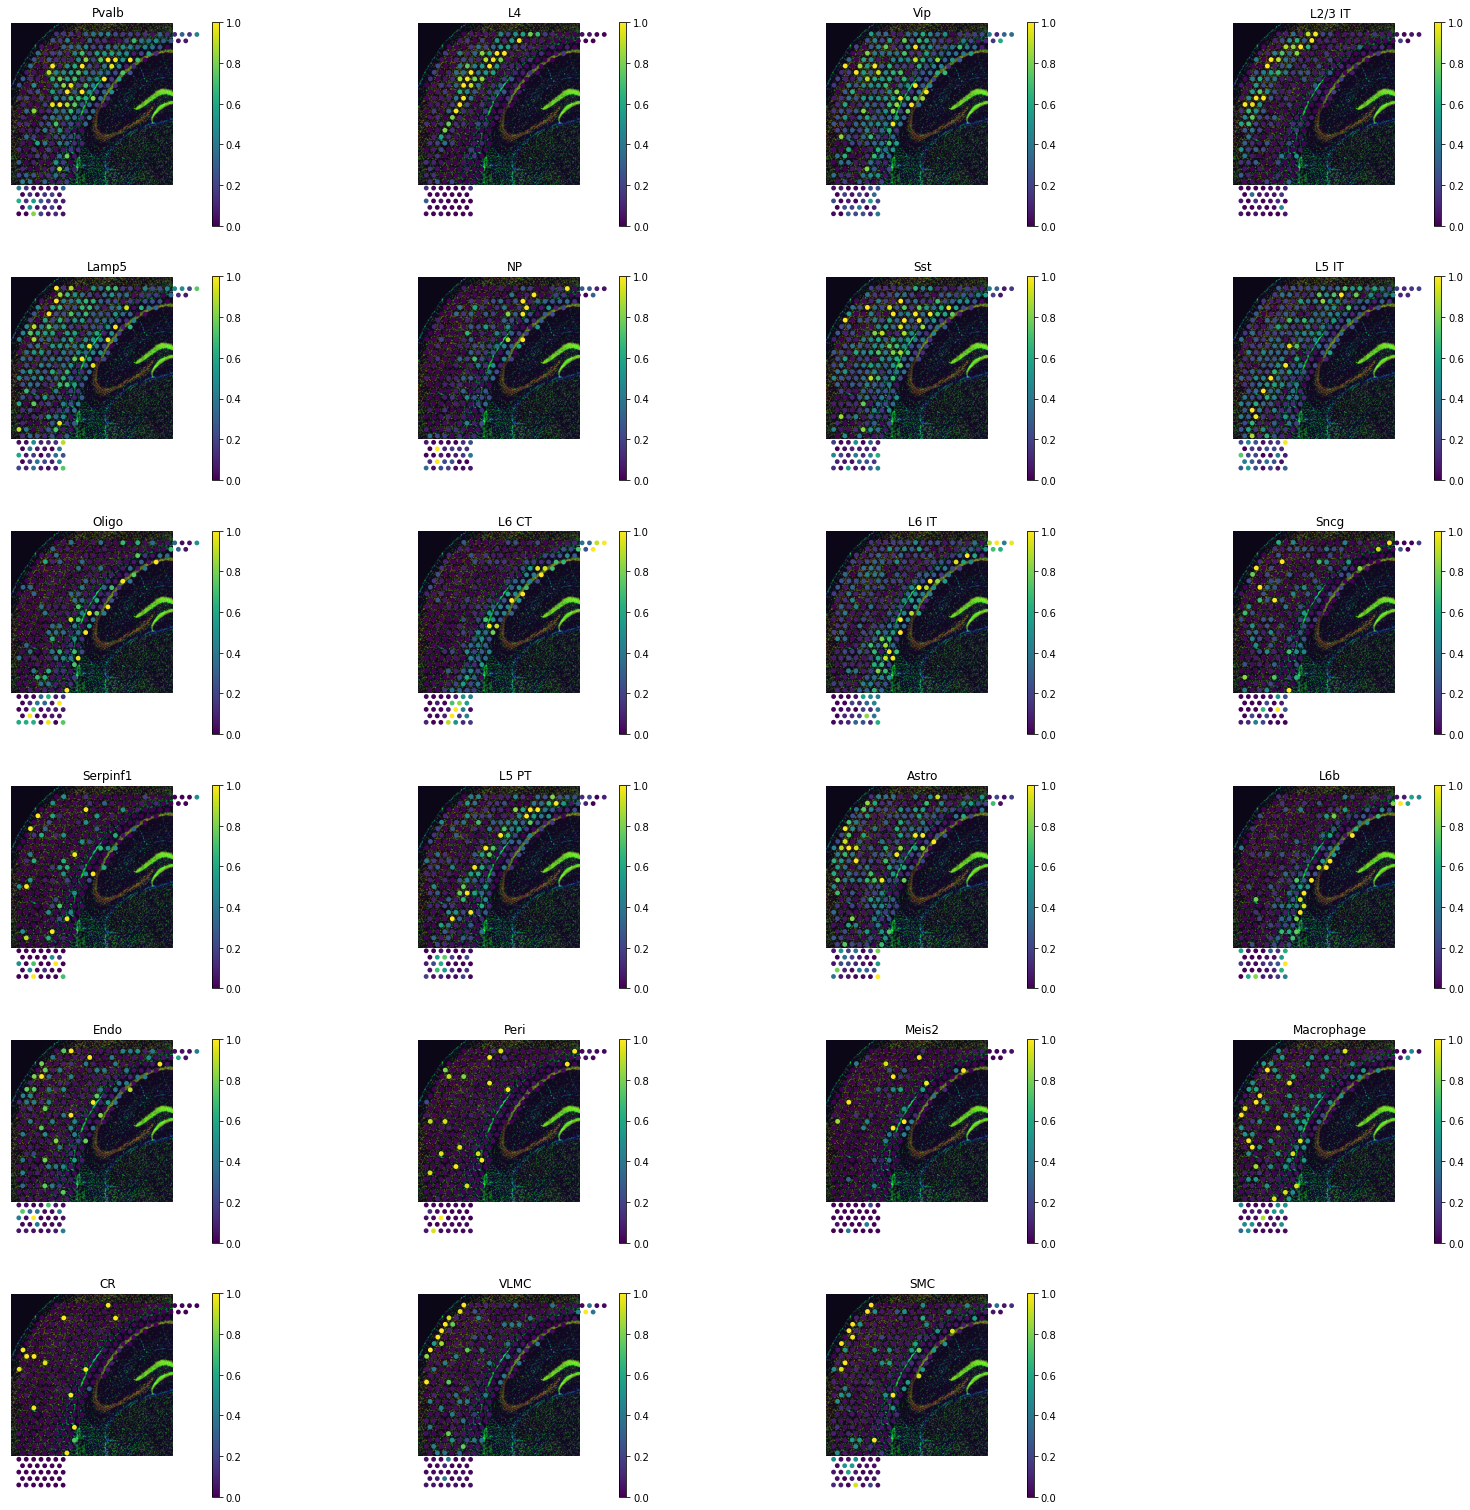

In [123]:
annotation_list = list(pd.unique(adata_sc.obs['cell_subclass']))

plot_cell_annotation_sc(adata_st, annotation_list, perc=0.02)


<Figure size 432x288 with 0 Axes>

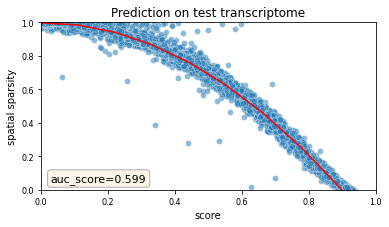

In [127]:
ad_ge = tg.project_genes(adata_map=adata_map, adata_sc=adata_sc)
df_all_genes = tg.compare_spatial_geneexp(ad_ge, adata_st, adata_sc)
tg.plot_auc(df_all_genes);

In [128]:
tg.create_segment_cell_df(adata_st)
adata_st.uns["tangram_cell_segmentation"].head()

spot_idx            y           x             centroids
0  AAATGGCATGTCTTGT-1  5304.000000  731.000000  AAATGGCATGTCTTGT-1_0
1  AAATGGCATGTCTTGT-1  5320.947519  721.331554  AAATGGCATGTCTTGT-1_1
2  AAATGGCATGTCTTGT-1  5332.942342  717.447904  AAATGGCATGTCTTGT-1_2
3  AAATGGCATGTCTTGT-1  5348.865384  558.924248  AAATGGCATGTCTTGT-1_3
4  AAATGGCATGTCTTGT-1  5342.124989  567.208502  AAATGGCATGTCTTGT-1_4

## count cell annotations and deconvolve the spots 

In [148]:
annotation = "cell_subclass"

In [147]:
## for each spot in the spatial dataset get the coordinates of the spot and the number of cells in that spot 
## and the most probable voxel for each cell


xs = adata_st.obsm["spatial"][:, 1]
ys = adata_st.obsm["spatial"][:, 0]
cell_count = adata_st.obsm["image_features"]["segmentation_label"]

df_segmentation = adata_st.uns["tangram_cell_segmentation"]
centroids = adata_st.obsm["tangram_spot_centroids"]

# create a dataframe has voxels i.e. the spots 
df_vox_cells = df_vox_cells = pd.DataFrame(
    data={"x": xs, "y": ys, "cell_n": cell_count, "centroids": centroids},
    index=list(adata_st.obs.index),
)

# get the most probable voxel for each cell
resulting_voxels = np.argmax(adata_map.X, axis=1)


In [81]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


In [82]:
path = os.path.join('./data', 'slideseq_MOp_1217.h5ad')
ad_sp = sc.read_h5ad(path)
ad_sp

AnnData object with n_obs × n_vars = 9852 × 24518
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'x', 'y'

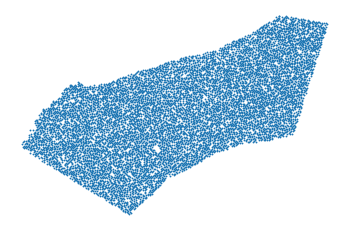

In [83]:
xs = ad_sp.obs.x.values
ys = ad_sp.obs.y.values
plt.axis('off')
plt.scatter(xs, ys, s=.7);
plt.gca().invert_yaxis()

In [84]:
path = os.path.join('data','mop_sn_tutorial.h5ad')
ad_sc = sc.read_h5ad(path)
ad_sc

AnnData object with n_obs × n_vars = 26431 × 27742
    obs: 'QC', 'batch', 'class_color', 'class_id', 'class_label', 'cluster_color', 'cluster_labels', 'dataset', 'date', 'ident', 'individual', 'nCount_RNA', 'nFeature_RNA', 'nGene', 'nUMI', 'project', 'region', 'species', 'subclass_id', 'subclass_label'
    layers: 'logcounts'

In [85]:
np.unique(ad_sc.X.toarray()[0, :])


array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  33.,
        34.,  36.,  39.,  40.,  43.,  44.,  46.,  47.,  49.,  50.,  53.,
        56.,  57.,  58.,  62.,  68.,  69.,  73.,  77.,  80.,  85.,  86.,
        98., 104., 105., 118., 121., 126., 613.], dtype=float32)

In [86]:
sc.pp.normalize_total(ad_sc)


In [87]:
ad_sc.obs.subclass_label.value_counts()


L5 IT        5623
Oligo        4330
L2/3 IT      3555
L6 CT        3118
Astro        2600
Micro-PVM    1121
Pvalb         972
L6 IT         919
L5 ET         903
L5/6 NP       649
Sst           627
Vip           435
L6b           361
Endo          357
Lamp5         332
VLMC          248
Peri          187
Sncg           94
Name: subclass_label, dtype: int64

In [88]:
df_genes = pd.read_csv('data/MOp_markers.csv', index_col=0)
markers = np.reshape(df_genes.values, (-1, ))
markers = list(markers)


In [92]:
tg.pp_adatas(ad_sc, ad_sp, genes=markers)


INFO:root:249 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:18000 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [93]:
assert ad_sc.uns['training_genes'] == ad_sp.uns['training_genes']


In [215]:
training_genes = ad_sc.uns["training_genes"]
S = np.array(ad_sc[:, training_genes].X.toarray(), dtype="float32",)
G = np.array(ad_sp[:, training_genes].X, dtype="float32")

In [216]:
S.shape, G.shape

((26431, 249), (9852, 249))

    Instantiate the Tangram optimizer (without filtering).
            Args:
                S (ndarray): Single nuclei matrix, shape = (number_cell, number_genes).
                G (ndarray): Spatial transcriptomics matrix, shape = (number_spots, number_genes).
                    Spots can be single cells or they can contain multiple cells.
                d (ndarray): Spatial density of cells, shape = (number_spots,). If not provided, the density term is ignored.
                    This array should satisfy the constraints d.sum() == 1.
                d_source (ndarray): Density of single cells in single cell clusters. To be used when S corresponds to cluster-level expression.
                    This array should satisfy the constraint d_source.sum() == 1.
                lambda_g1 (float): Optional. Strength of Tangram loss function. Default is 1.
                lambda_d (float): Optional. Strength of density regularizer. Default is 0.
                lambda_g2 (float): Optional. Strength of voxel-gene regularizer. Default is 0.
                lambda_r (float): Optional. Strength of entropy regularizer. An higher entropy promotes
                                  probabilities of each cell peaked over a narrow portion of space.
                                  lambda_r = 0 corresponds to no entropy regularizer. Default is 0.
                device (str or torch.device): Optional. Device is 'cpu'.
                adata_map (scanpy.AnnData): Optional. Mapping initial condition (for resuming previous mappings). Default is None.
                random_state (int): Optional. pass an int to reproduce training. Default is None.


### the matching functional is kind of simple 
$M^TS$ is $n_{voxels}$ x $n_{genes}$ and this should match the matrix $G$ which is $n_{voxels}$ x $n_{genes}$  as well. $S$ is $n_{cells}$ x $n_{genes}$

In [246]:
from  optax import cosine_similarity as cosim
from functools import partial
from jax import value_and_grad
import optax

In [149]:
## every cell is assigned to a voxel now keep only those cells i.e. voxels  which pass the filtering 

filtered_voxels_to_types = [
    (j, adata_sc.obs[annotation][k])
    for i, j, k in zip(
        adata_map.obs["F_out"], resulting_voxels, range(len(adata_sc))
    )
    if i > threshold
]

vox_ct = filtered_voxels_to_types



In [161]:
df_classes = one_hot_encoding(adata_sc.obs[annotation])
## initialize the df_vox_cells_with_all zeros first
for index, i in enumerate(df_classes.columns):
    df_vox_cells[i] = 0


for k, v in vox_ct:
    df_vox_cells.iloc[k, df_vox_cells.columns.get_loc(v)] += 1

adata_st.obsm["tangram_ct_count"] = df_vox_cells


In [165]:
segmentation_df = adata_st.uns["tangram_cell_segmentation"]

In [171]:
from tangram.utils import df_to_cell_types, deconvolve_cell_annotations

In [ ]:
## now within a spot each cell is randomly assigned the required the subclass label 

In [168]:
filter_cell_annotation = pd.unique(
            list(adata_st.obsm["tangram_ct_pred"].columns)
        )
filter_cell_annotation

array(['Pvalb', 'L4', 'Vip', 'L2/3 IT', 'Lamp5', 'NP', 'Sst', 'L5 IT',
       'Oligo', 'L6 CT', 'L6 IT', 'Sncg', 'Serpinf1', 'L5 PT', 'Astro',
       'L6b', 'Endo', 'Peri', 'Meis2', 'Macrophage', 'CR', 'VLMC', 'SMC'],
      dtype=object)

In [169]:
cell_types_mapped = df_to_cell_types(df_vox_cells, filter_cell_annotation)

In [172]:
adata_seg = deconvolve_cell_annotations(adata_st, filter_cell_annotation=None)

In [174]:
adata_seg.obs.head()

y           x             centroids cluster
0  5304.000000  731.000000  AAATGGCATGTCTTGT-1_0   Pvalb
1  5320.947519  721.331554  AAATGGCATGTCTTGT-1_1     Vip
2  5332.942342  717.447904  AAATGGCATGTCTTGT-1_2     Sst
3  5348.865384  558.924248  AAATGGCATGTCTTGT-1_3   L5 IT
4  5342.124989  567.208502  AAATGGCATGTCTTGT-1_4   L6 CT

[<AxesSubplot:title={'center':'cluster'}, xlabel='spatial1', ylabel='spatial2'>]

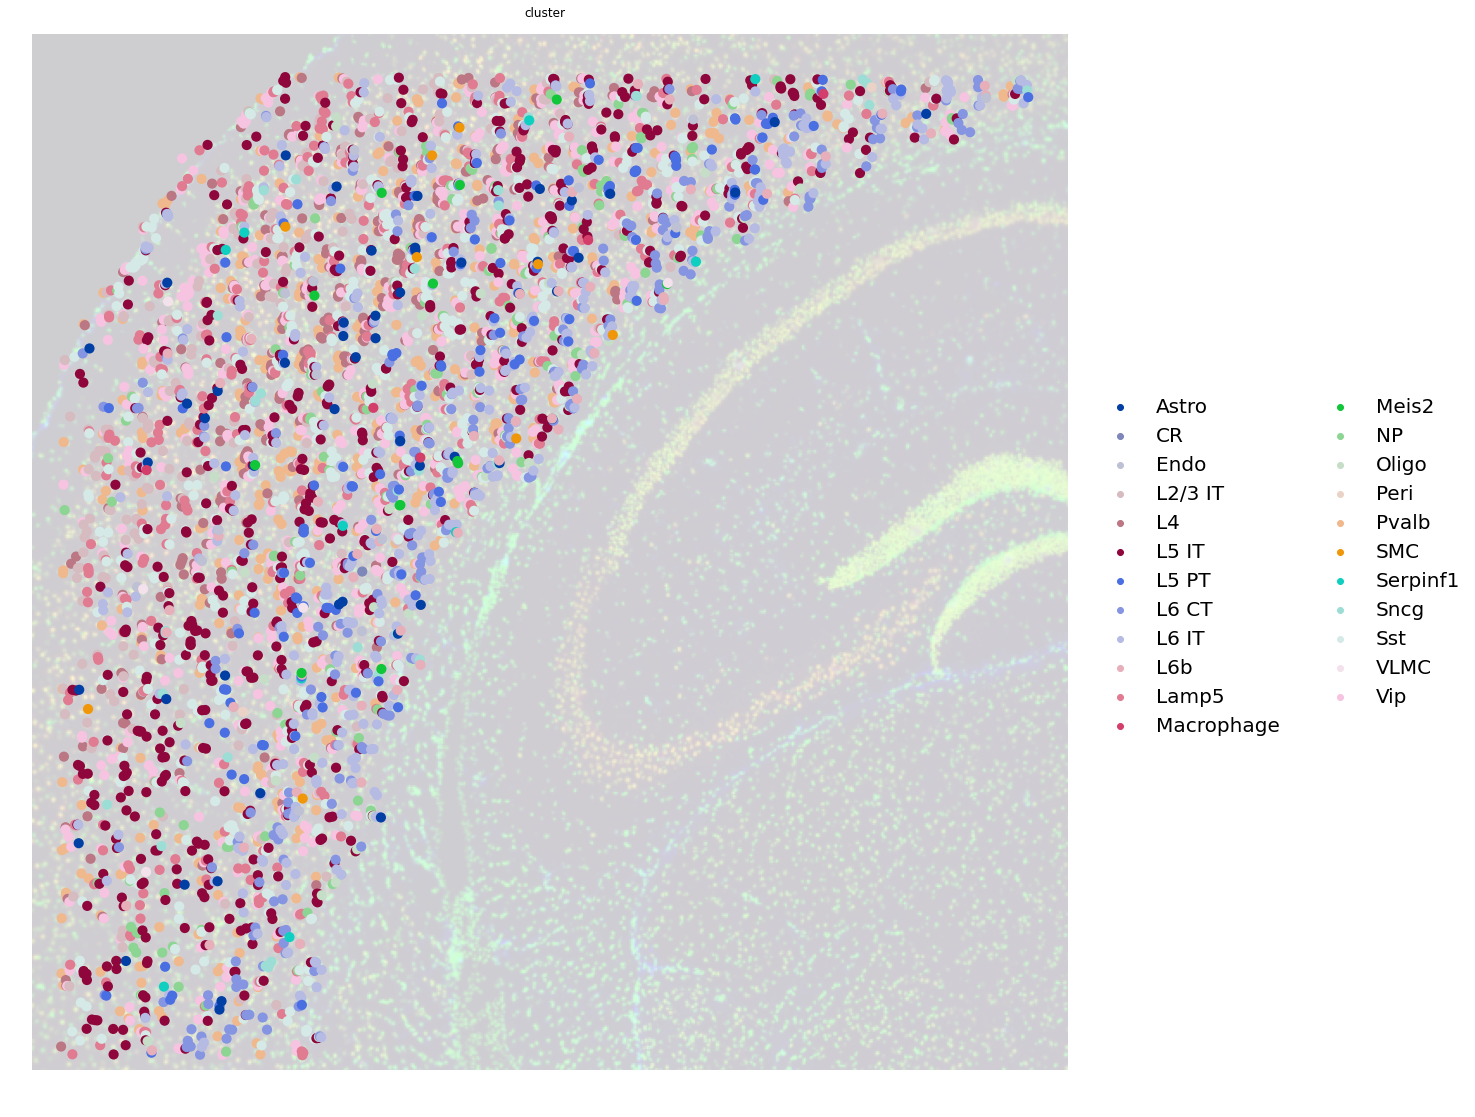

In [173]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sc.pl.spatial(
    adata_seg,
    color="cluster",
    size=0.4,
    show=False,
    frameon=False,
    alpha_img=0.2,
    legend_fontsize=20,
    ax=ax,
)